# Finding Lanes

In this iPython notebook I will demonstrate the pipeline followed to detect lane lines in images and video

## Loading Images and Calibration Data

- Here we will load the calibration matrix and distortion co-efficient for the camera

In [119]:
import glob
import pickle

# Loading images
files = glob.glob('test_images/*.jpg')

# Loading Camera Calibration Data
with open('camera_calibration.p', mode='rb') as file:
    dist_pickle = pickle.load(file)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

print('Data Loaded')

Data Loaded


## Importing Required Modules

In [120]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np

%matplotlib inline

## Helper Functions

- Following functions are used to perform various operations on the image as mentioned in the comments

In [157]:
# Function to detect edges in the image and convert it into binary form
def detectEdges(img, thresh_saturation, thresh_sobelX, thresh_lightness):    
    # Converting to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # Extracting saturation and lightness channel
    lightness_channel = hls_img[:,:,1]
    saturation_channel = hls_img[:,:,2]
    
    # Applying x- derivative of Sobel Edge Detection Matrix
    sobelX = cv2.Sobel(lightness_channel, cv2.CV_64F, 1, 0) 
    abs_sobelX = np.absolute(sobelX)
    
    # Normalzing the achieved output in the range 0-255 for further image related operations
    scaled_sobel = np.uint8(255*abs_sobelX/np.max(abs_sobelX))
       
    # Preparing binary image    
    binary = np.zeros_like(saturation_channel)
    
    # Pixel is set to high i.e. 1 if:
    #     a. Lightness channel is within the threshold `and` Saturation Channel is within the threshold
    #  `or` b. The x- derivative of Sobel is within the threshold 
    
    binary[((((lightness_channel >= thresh_lightness[0]) & (lightness_channel <= thresh_lightness[1]) )& 
            ((saturation_channel >= thresh_saturation[0]) & (saturation_channel <=thresh_saturation[1])))| 
            ((scaled_sobel >= thresh_sobelX[0]) & (scaled_sobel <= thresh_sobelX[1])))] = 1
           
    return  binary

# Function to transform the perspective of the image to bird-eye view
def perspectiveTransform(img):
    imshape = img.shape
    
    # Offset for the destination points
    offset = 250
    
    # Defining source and destination points
    src = np.float32([[(589, 458),(698, 458), (1145, imshape[0]), (190,imshape[0])]])
    dst = np.float32([[offset, 0], [imshape[1]-offset, 0], [imshape[1]-offset, imshape[0]], [offset, imshape[0]]])
    
    # Transforming the image
    M = cv2.getPerspectiveTransform(src, dst)
        
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (imshape[1], imshape[0]))
    
    # Calculating inverse transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return Minv, warped

# Function to convert values from Image Space to World Space
#    - used for calculation of curvature and distance
def convertToWorldSpace(leftx, lefty, rightx, righty, y):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx = leftx * xm_per_pix
    lefty = lefty * ym_per_pix
    
    rightx = rightx * xm_per_pix
    righty = righty * ym_per_pix
    
    y = ym_per_pix * y
    
    return leftx, lefty, rightx, righty, y

# Function to calculate curvature of the road
def curvature(leftx, lefty, rightx, righty, y):
    
    leftx, lefty, rightx, righty, y = convertToWorldSpace(leftx, lefty, rightx, righty, y)
    
    # Fitting the point for the left and right curvature equation
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Calculatin radius of curvature using the formula Radius = (( 1 + (2Ay + B)^2)^3/2)/ |2A|
    left_curve = np.power( (1 + np.power((2*left_fit[0]*y + left_fit[1]), 2)),1.5) / np.absolute(2 * left_fit[0])
    right_curve = np.power( (1 + np.power((2*right_fit[0]*y + right_fit[1]), 2)),1.5) / np.absolute(2 * right_fit[0])
    
    # Returning average radius of curvature
    return ( left_curve + right_curve ) / 2

def distanceFromCentre(leftx, lefty, rightx, righty, y, img_centre):
    
    # Converting points to world space
    leftx, lefty, rightx, righty, y = convertToWorldSpace(leftx, lefty, rightx, righty, y)
    
    # Fitting points to fetch equations of left and right lane lines
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Calculating position of left and right lane
    left_boundary = np.power(left_fit[0] * y, 2) + (left_fit[1] * y) + left_fit[2]
    right_boundary = np.power(right_fit[0] * y, 2) + (right_fit[1] * y) + right_fit[2]
    
    #  Calculating centre of lane
    vehicle_centre = ( right_boundary +  left_boundary ) / 2
    
    # Calculating the amount of distance the vehicle is lying left of the lane
    return img_centre * 3.7/700 - vehicle_centre
       
# Function to find lanes in the image
def findLanes(img):
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    
    # Calculating mid- point of histogram
    midpoint = np.int(histogram.shape[0]/2)
    
    # Dividing histogram into two parts
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Number of windows to divide the lane
    nwindows = 50
    
    # Calculating window height
    window_height = np.int(img.shape[0]/nwindows)
    
    # Preparing list of indices having non-zero values
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
       
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Calculating radius of curvature
    yvalue = img.shape[0]

    curve = curvature(leftx, lefty, rightx, righty, yvalue)
    
    # Calculating distance from the centre of the image
    distance = distanceFromCentre(leftx, lefty, rightx, righty, yvalue, img.shape[1]/2)
    
    return left_fitx, left_fit, ploty,right_fitx, right_fit, curve, distance


# Function to find lanes using the points fetched in previous iteration
def findLanesWithPreviousFit(img, left_fit, right_fit):
    
    '''
        This function is used to optimize the process of finding the window as per Sliding Window Algo
        The function uses the points fetched in previous frame and fetches lanes around it
        Used in processing of a video
    '''
    
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    
    # Dividing the hostogram in left and right region
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Number of windows to divide the lane
    nwindows = 50
    
    # Calculating window height
    window_height = np.int(img.shape[0]/nwindows)
    
    # Getting indices of non-zero values
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Margin around which the lane points will  be fetched
    margin = 100

    # Finding left and right indices
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Calculating radius of curvature
    yvalue = img.shape[0]

    curve = curvature(leftx, lefty, rightx, righty, yvalue)
    
    # Calculating distance from centre
    distance = distanceFromCentre(leftx, lefty, rightx, righty, yvalue, img.shape[1]/2)
    return left_fitx, left_fit, ploty,right_fitx, right_fit, curve, distance


## Processing A Sample

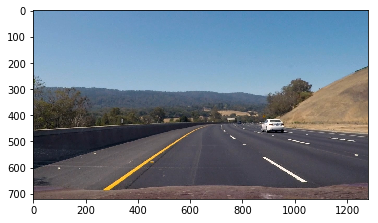

In [158]:
# Reading image
img = mpimg.imread('test_images/test3.jpg')

plt.imshow(img)

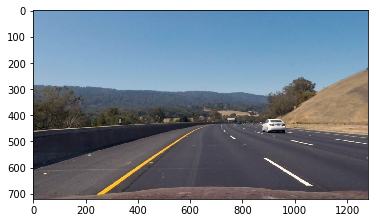

In [159]:
# Undistorting image

undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imsave('output_images/Image_Pipeline/undistorted_sample.jpg', undist)

plt.imshow(undist)

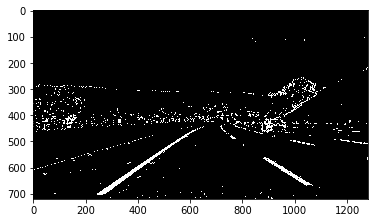

In [160]:
# Detecting edges of the image and converting to binary form
edge_img = detectEdges(undist, (120, 255), (20, 255), (40,255))

plt.imsave('output_images/Image_Pipeline/binary_sample.jpg', edge_img, cmap='gray')
plt.imshow(edge_img, cmap='gray')

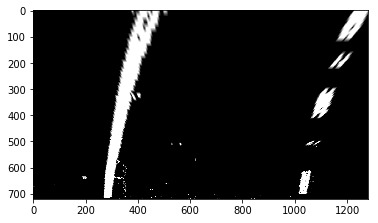

In [161]:
# Applying perspective transformation
Minv, warped_img = perspectiveTransform(edge_img)

plt.imsave('output_images/Image_Pipeline/perspective_transformed_sample.jpg', warped_img, cmap='gray')
plt.imshow(warped_img, cmap='gray')

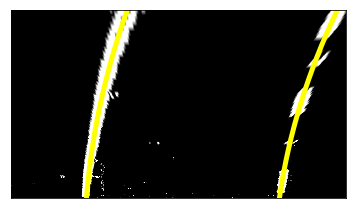

In [162]:
# Finding lanes on the image
left_fitx, left_fit,ploty,right_fitx, right_fit, curv, distance = findLanes(warped_img)

plt.imshow(warped_img, cmap='gray')
plt.plot(left_fitx, ploty, color='yellow', linewidth=5)
plt.plot(right_fitx, ploty, color='yellow', linewidth=5)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

plt.savefig('output_images/Image_Pipeline/finding_lanes_sample.jpg')

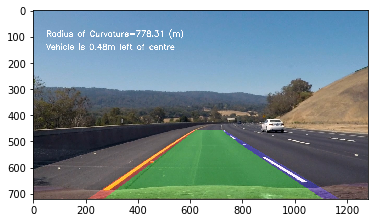

In [163]:
# Plotting the final result
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_img).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
cv2.polylines(color_warp,np.int_([pts_left]),True,(255,0,0), thickness = 50)
cv2.polylines(color_warp,np.int_([pts_right]),True,(0,0,255), thickness = 50)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
curv_str = str('Radius of Curvature='+str( "{0:.2f}".format(curv))+' (m)')
cv2.putText(result,curv_str,(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

if distance >= 0:
    dist_str = str('Vehicle is '+str( "{0:.2f}".format(distance))+'m left of centre')
else:
    dist_str = str('Vehicle is '+str( "{0:.2f}".format(-distance))+'m right of centre')
    
cv2.putText(result,dist_str,(50,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
        
plt.imshow(result)

## Pipeline to Detect Lanes

Now we will perform the above task on all the images

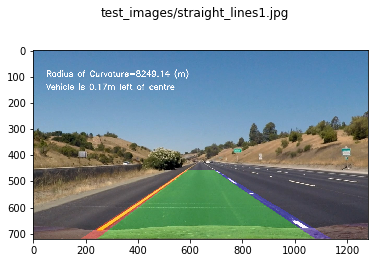

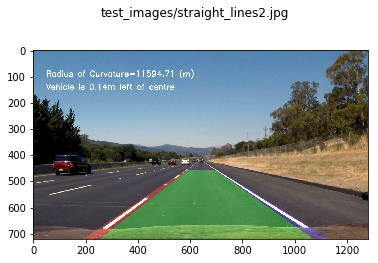

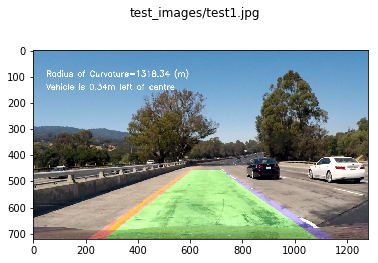

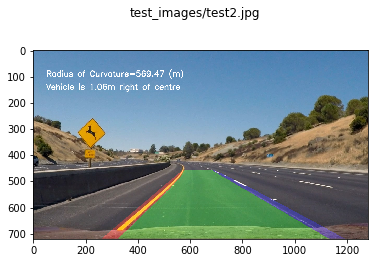

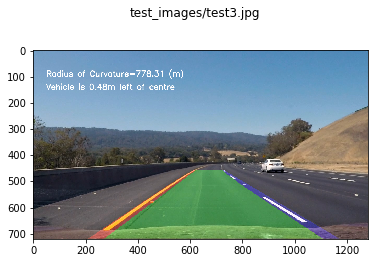

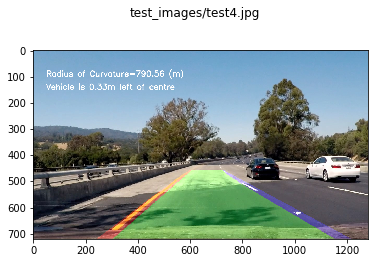

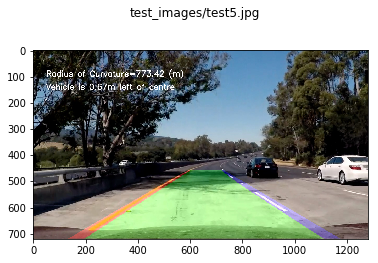

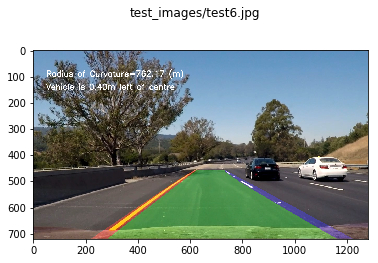

In [164]:
for fname in files:
    img = mpimg.imread(fname)
    
    # Undistorting image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Finding Edges and Binarizing the Image
    edge_img = detectEdges(undist, (120, 255), (20, 255), (40,255))
    
    # Warping the image
    Minv, warped_img = perspectiveTransform(edge_img)
    
    # Finding lane points for the left and right lane
    left_fitx, left_fit,ploty,right_fitx, right_fit, curv, distance = findLanes(warped_img)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp,np.int_([pts_left]),True,(255,0,0), thickness = 50)
    cv2.polylines(color_warp,np.int_([pts_right]),True,(0,0,255), thickness = 50)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Displaying curvature on the image
    curv_str = str('Radius of Curvature='+str("{0:.2f}".format(curv))+' (m)')
    cv2.putText(result,curv_str,(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    
    # Displaying distance from centre on the image
    if distance >= 0:
        dist_str = str('Vehicle is '+str("{0:.2f}".format(distance))+'m left of centre')
    else:
        dist_str = str('Vehicle is '+str("{0:.2f}".format(-distance))+'m right of centre')
    
    cv2.putText(result,dist_str,(50,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    
    # Plotting result
    fig = plt.figure()
    fig.suptitle(fname)
    ax = fig.add_subplot(111)
    ax.imshow(result)
    
    output_fname = 'output_images/' + fname.split('/')[1]
    plt.imsave(output_fname, result)

## Pipeline to Detect Lanes (Video)

In [165]:
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [166]:
# Function to process each frame of the video
def process_image(img):
    
    # Undistorting image
    undist = undistort(img)
    
    # Converting to Gray Scale
    edge_img = detectEdges(undist, (120, 255), (20, 255), (40,255))
    
    Minv, warped_img = perspectiveTransform(edge_img)
    
    global left_fit
    global right_fit
    
    # If we do not have set of points from the previous frame, apply exhaustive search for sliding window
    if len(left_fit) == 0:
        left_fitx, left_fit, ploty,right_fitx, right_fit, curv, distance = findLanes(warped_img)
    # Else find the sliding window around the previously obtained set of points
    else:
        left_fitx, left_fit, ploty,right_fitx, right_fit, curv, distance = findLanesWithPreviousFit(warped_img, left_fit, right_fit)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp,np.int_([pts_left]),True,(255,0,0), thickness = 50)
    cv2.polylines(color_warp,np.int_([pts_right]),True,(0,0,255), thickness = 50)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Displaying curvature
    curv_str = str('Radius of Curvature = '+str("{0:.2f}".format(curv))+'m')
    cv2.putText(result,curv_str,(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    
    # Displaying distance from the centre
    if distance >= 0:
        dist_str = str('Vehicle is '+str("{0:.2f}".format(distance))+'m left of centre')
    else:
        dist_str = str('Vehicle is '+str("{0:.2f}".format(-distance))+'m right of centre')
    cv2.putText(result,dist_str,(50,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
        
    
    return result

In [167]:
white_output = 'video1.mp4'
clip1 = VideoFileClip("project_video.mp4")

left_fit = []
right_fit = []
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video video1.mp4
[MoviePy] Writing video video1.mp4


100%|█████████▉| 1260/1261 [04:13<00:00,  5.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video1.mp4 

CPU times: user 4min 5s, sys: 57 s, total: 5min 2s
Wall time: 4min 14s


In [168]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))